In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os


%matplotlib inline

In [2]:
path_current = 'D:\\Measurements\\Josip\\20170819\\205904_IV_BYsweep_Da_819.62mV_13-10_G08_current'
path_lockin = 'D:\\Measurements\\Josip\\20170819\\205904_IV_BYsweep_Da_819.62mV_13-10_G08_LF_lockin'

In [4]:
for file in glob.glob(path_current+"\\*.dat"):
    path_I = file
    
for file in glob.glob(path_current+"\\*.dat_matrix"):
    path_I_matrix = file
    
for file in glob.glob(path_lockin+"\\*.dat"):
    path_lock = file
    
for file in glob.glob(path_lockin+"\\*.dat_matrix"):
    path_lockin_matrix = file
    

current = pd.read_csv(path_I, sep = '\t',skiprows = 15, header = None)
lockin = pd.read_csv(path_lock, sep = '\t',skiprows = 15, header = None)
I_matrix = np.loadtxt(path_I_matrix)
lockin_matrix = np.loadtxt(path_lockin_matrix)

In [5]:
bias_div_factor = 1.0  # 1.0 if it is taken into account already, otherwise proper factor need to be put
Vb = current[0]/bias_div_factor  # mV
I = current[2]  # pA 
dI = lockin[2]  # pA

In [6]:
dV = 5 # excitation in uV

In [7]:
# Correct the Vbias axis
Rtot = 122 #kohm
correction_factor = Rtot*1e-6  #for mV
Vbcorr = Vb - correction_factor*I

In [8]:
#interpolation
num_rows = len(I_matrix[:,1])
num_cols = len(I_matrix[1,:])
Icorr = np.zeros((num_rows, num_cols))
for i in xrange(num_cols):
    Icorr[:,i] = np.interp(Vb[(i*num_rows):((i+1)*num_rows)],Vbcorr[(i*num_rows):((i+1)*num_rows)],I_matrix[:,i])
    Vb_temp = Vb[(i*num_rows):((i+1)*num_rows)]
    Vbcorr_temp = Vbcorr[(i*num_rows):((i+1)*num_rows)]
    for j in xrange(len(Vb_temp)): # Kicking out all current values out of Vbcorr
        if abs(Vb_temp[i*num_rows+j]) > abs(Vbcorr_temp[i*num_rows+len(Vbcorr_temp)-1]):
            Icorr[j,i] = float('NaN')
print Icorr

[[ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]]


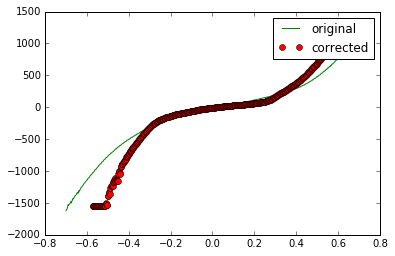

In [9]:
y = I_matrix[:,1]
Vbcorr1 = Vbcorr[0:num_rows]
Vb1 = Vb[0:num_rows]
plt.plot(Vb1,y,'g')
plt.plot(Vb1,Icorr[:,20],'ro')
plt.legend(['original','corrected'])

In [10]:
np.savetxt(path_I_matrix+'_corrected',Icorr)

In [11]:
#interpolation now for differential conductance
dIcorr = np.zeros((num_rows, num_cols))
for i in xrange(num_cols):
    dIcorr[:,i] = np.interp(Vb[(i*num_rows):((i+1)*num_rows)],Vbcorr[(i*num_rows):((i+1)*num_rows)],lockin_matrix[:,i])
    Vb_temp = Vb[(i*num_rows):((i+1)*num_rows)]
    Vbcorr_temp = Vbcorr[(i*num_rows):((i+1)*num_rows)]
    for j in xrange(len(Vb_temp)):
        if abs(Vb_temp[i*num_rows+j]) > abs(Vbcorr_temp[i*num_rows+len(Vbcorr_temp)-1]):
            dIcorr[j,i] = float('NaN')

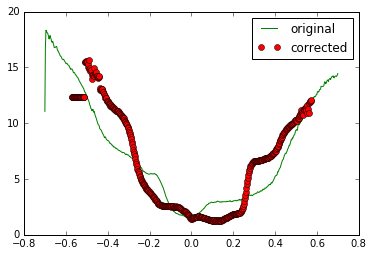

In [12]:
y = lockin_matrix[:,1]
plt.plot(Vb1,y,'g')
plt.plot(Vb1,dIcorr[:,20],'ro')
plt.legend(['original','corrected'])

In [13]:
np.savetxt(path_lockin_matrix+'_corrected',dIcorr)

C:\Users\nanoelectronics\AppData\Local\Enthought\Canopy32\User\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


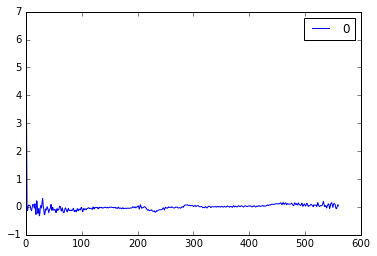

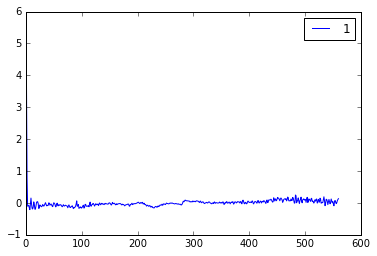

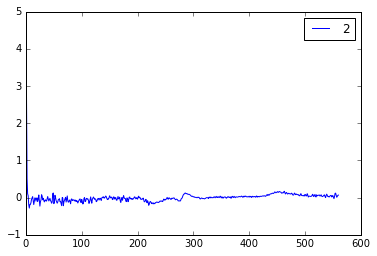

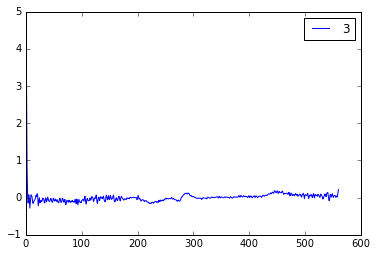

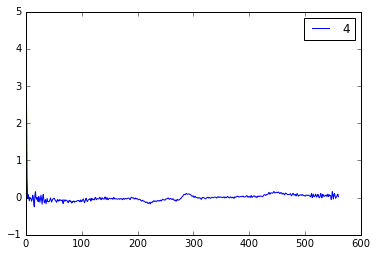

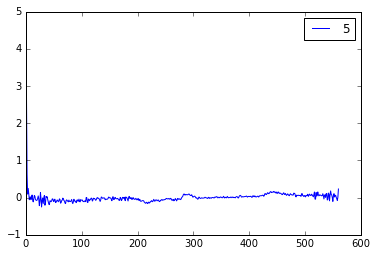

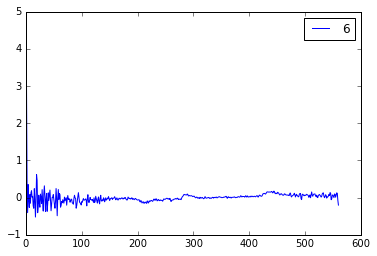

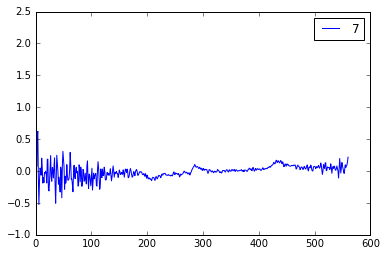

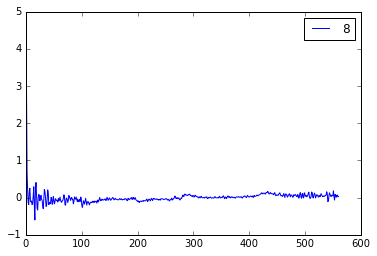

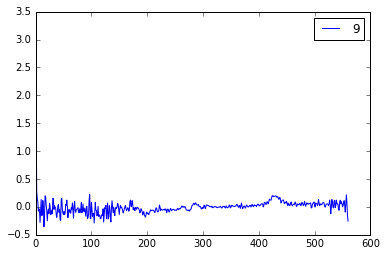

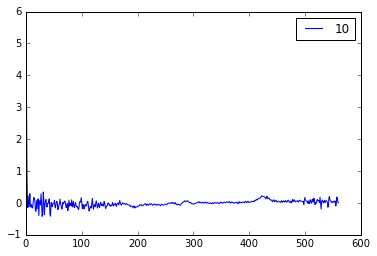

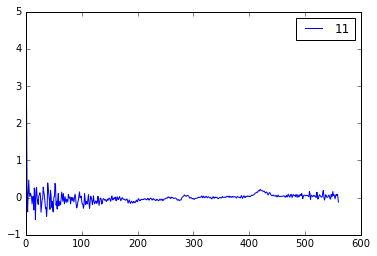

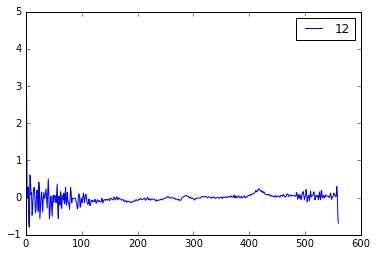

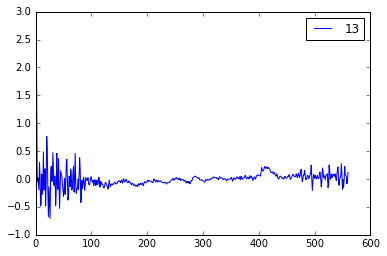

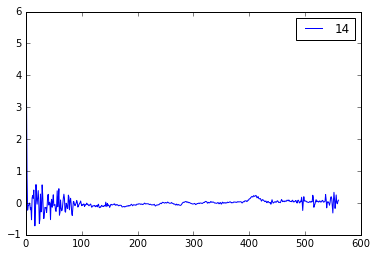

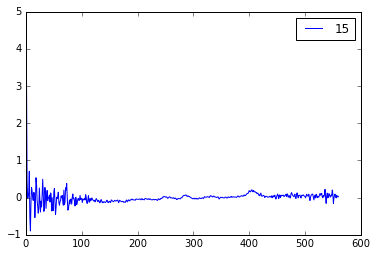

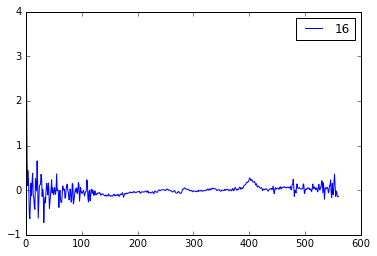

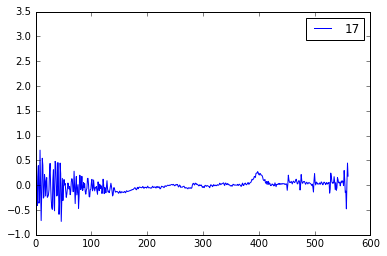

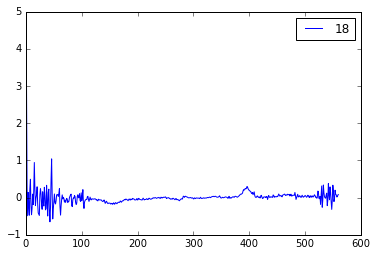

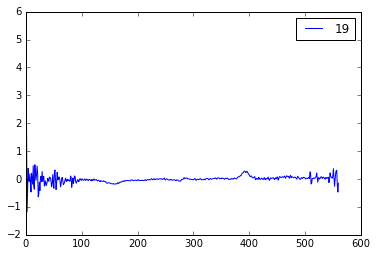

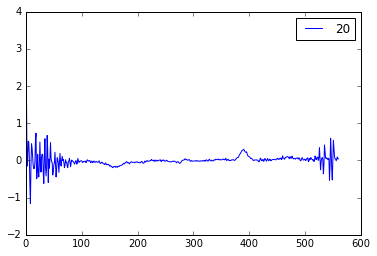

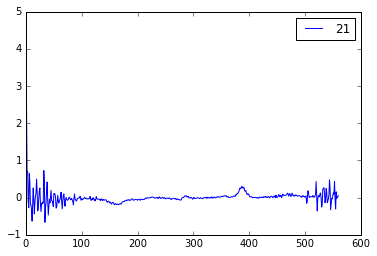

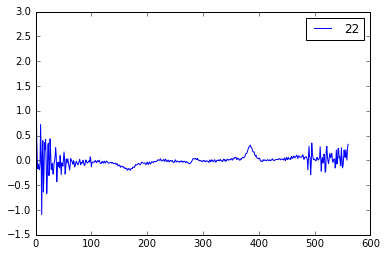

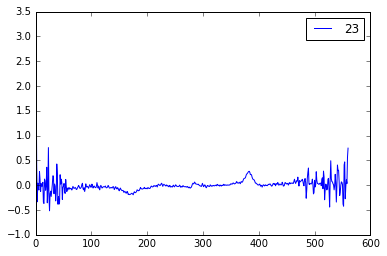

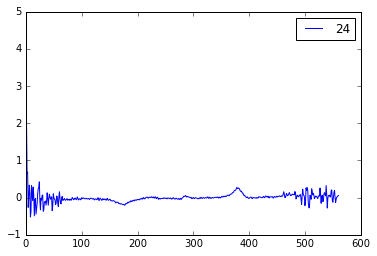

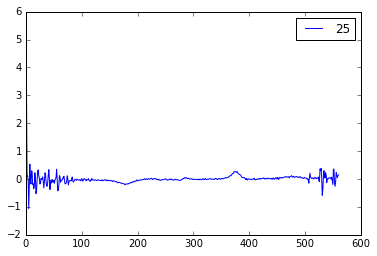

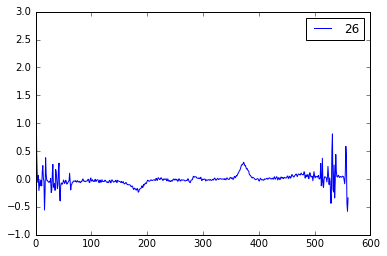

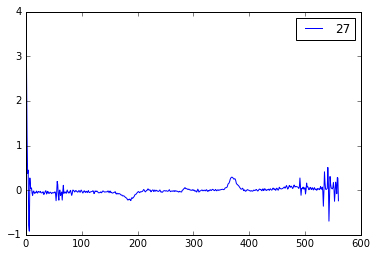

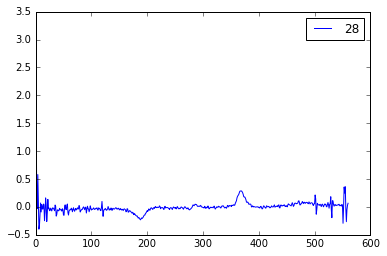

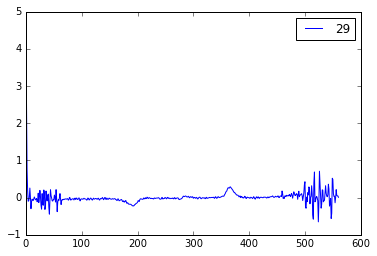

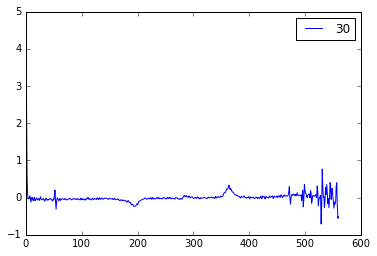

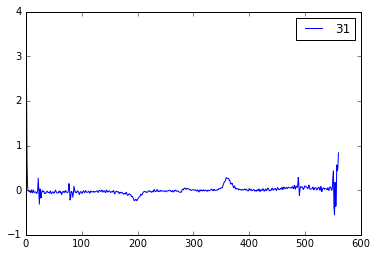

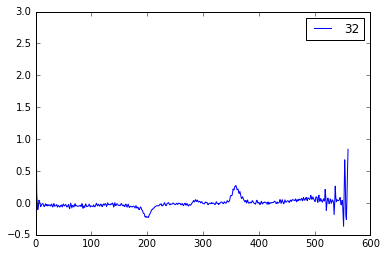

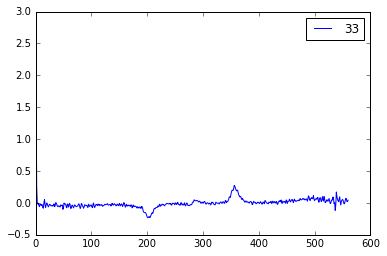

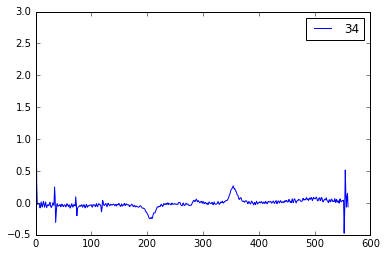

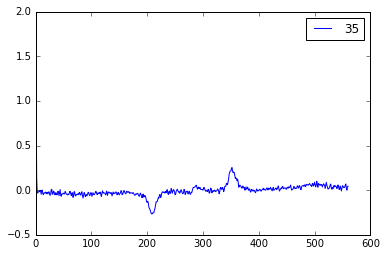

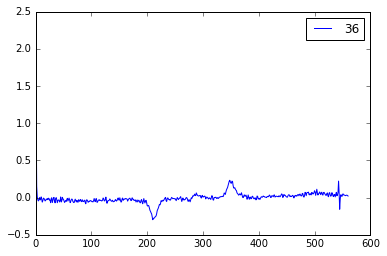

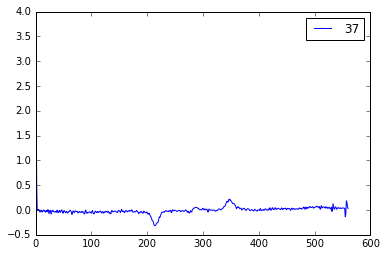

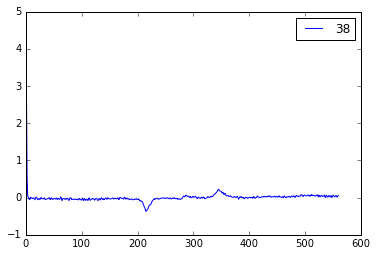

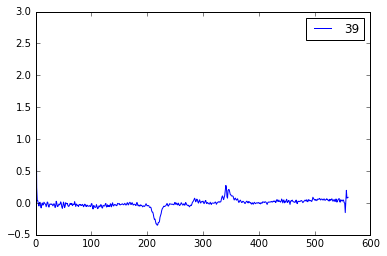

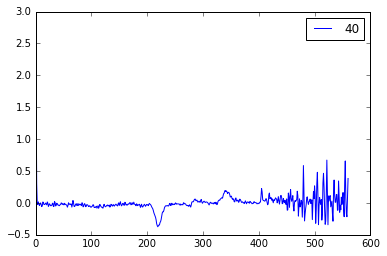

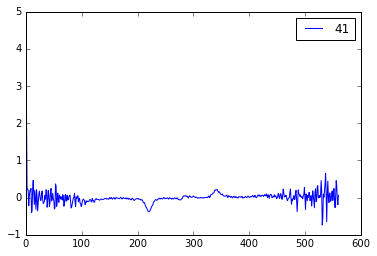

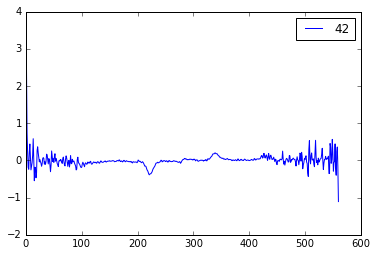

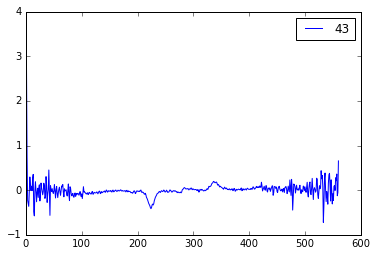

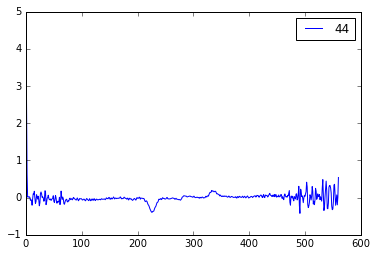

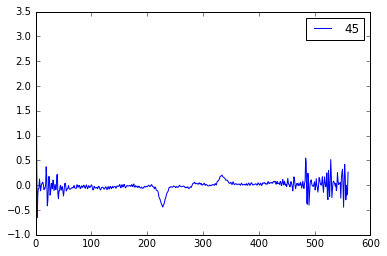

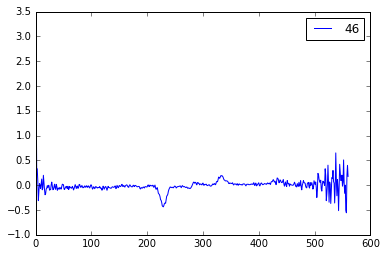

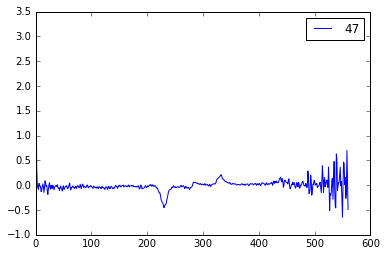

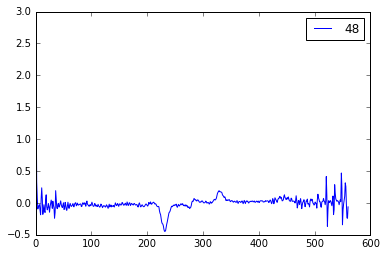

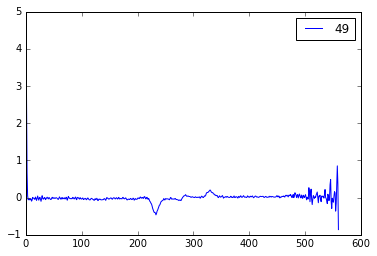

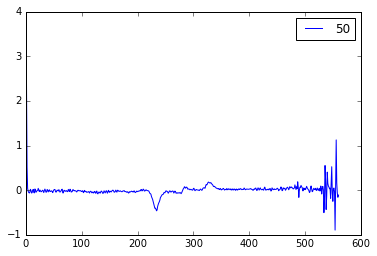

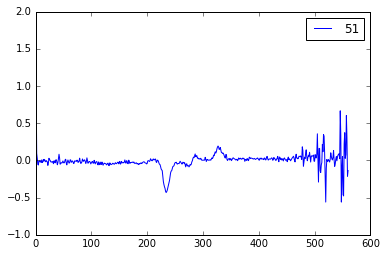

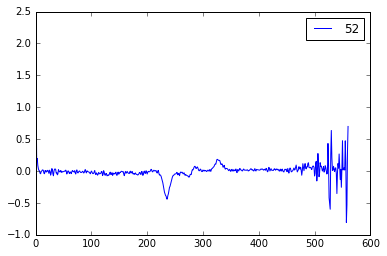

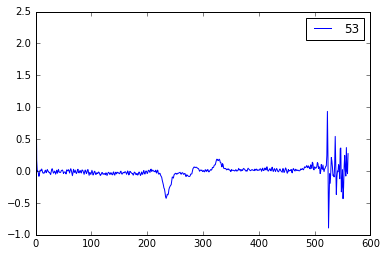

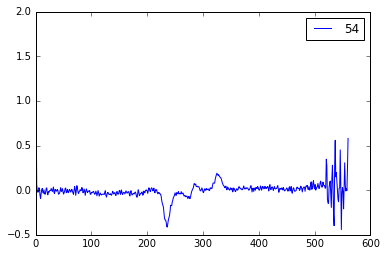

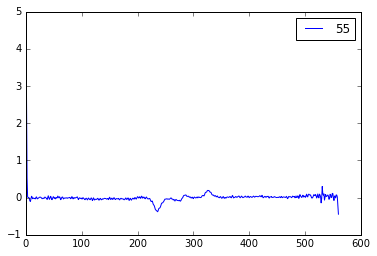

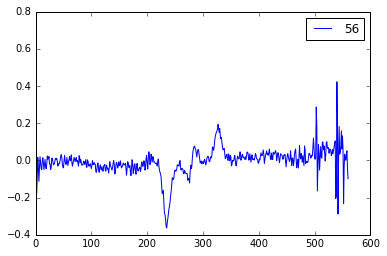

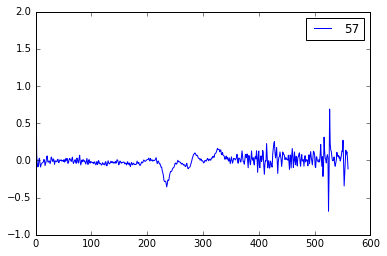

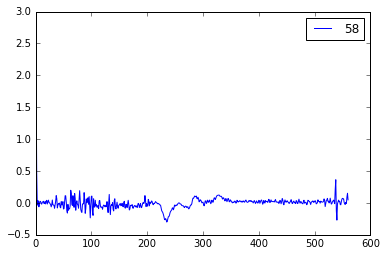

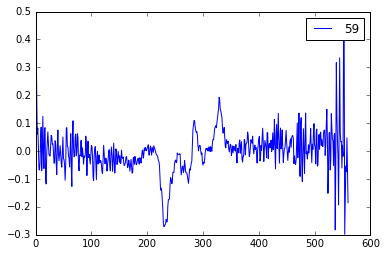

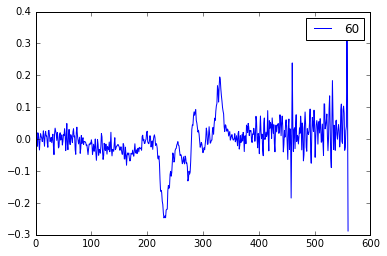

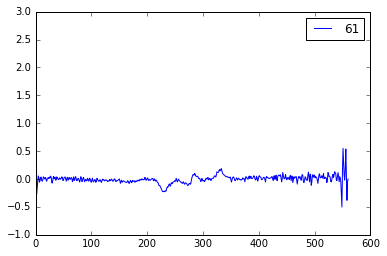

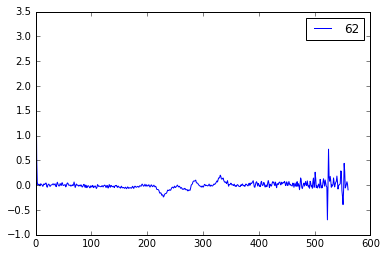

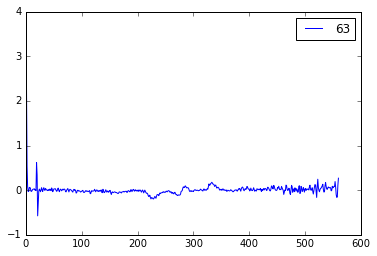

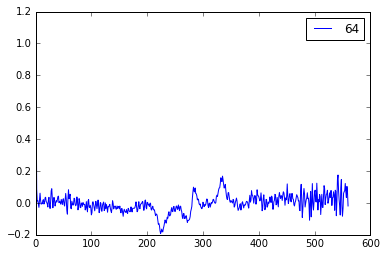

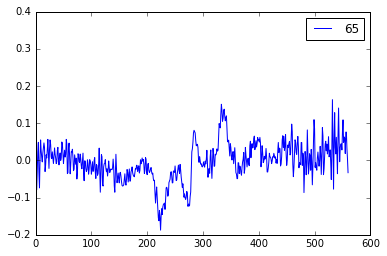

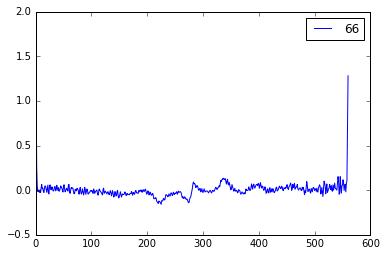

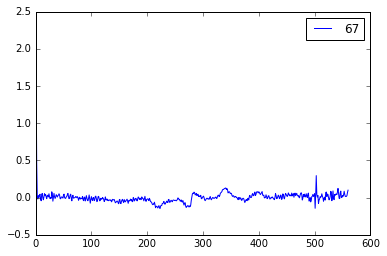

In [14]:
for i in xrange(len(lockin_matrix[1,:])):
    dy = np.gradient(lockin_matrix[:,i])
    plt.figure(i)
    plt.plot(dy)
    plt.legend([i])

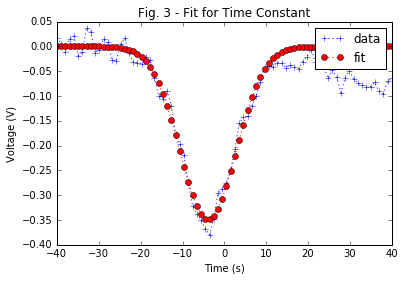

Full width at half maximum is 15.811160 hopefully! in ueV
Electron temp is 33.728236 mK


In [33]:
#extract FWHM and electron temperature (Te)  , code taken from https://stackoverflow.com/questions/19206332/gaussian-fit-for-python
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

y = np.gradient(lockin_matrix[200:280,55])   # Data to fit
x = np.linspace(-len(y)/2.0,len(y)/2.0,len(y))   # X axis for the gauss function, should be symetric around 0, should have the same
                                # number of elements as y

n = len(x)                          
mean = sum(y)/len(y)                   
sigma = 20.0          # Initial guess for sigma (approx FWHM/2)
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

plt.plot(x,y,'b+:',label='data')
plt.plot(x,gaus(x,*popt),'ro:',label='fit')
plt.legend()
plt.title('Fig. 3 - Fit for Time Constant')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()
sigma_fit = popt[2]
FWHM = 2*np.sqrt(2*np.log(2))*sigma_fit 
print "Full width at half maximum is %f hopefully! in ueV"%FWHM

# Electron temperature calculation
kB = 8.6173e-5  # Boltzmann constant
Te = FWHM*1e-6/(5.44*8.6173e-5)   # Calculation of electron temp, assumes FWHM in ueV
print "Electron temp is %f mK"%(Te*1000.0)

In [ ]:
# correct the value of dI
dVcorr = dV - correction_factor*dI
dIdV = 